# Bayes Final Project ADVI Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample, MvNormal 
import xarray as xr
import graphviz
import scipy
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
# Read in data
data = pd.read_csv('diabetes_binary.csv').astype(int)

In [5]:
# Make BMI categorical
new_bmi=list()
for i in list(data['BMI']): 
    if i<18.5:
        new_bmi.append(0)
    if 18.5<=i<25:
        new_bmi.append(1)
    if 25<=i<30:
        new_bmi.append(2)
    if 30<=i<35:
        new_bmi.append(3)
    if 35<=i:
        new_bmi.append(4)
data['BMI']=new_bmi

In [6]:
# Make MentHlth categorical
new_MH=list()
for i in list(data['MentHlth']):
    if 1<=i<6:
        new_MH.append(1)
    if 6<=i:
        new_MH.append(2)
    if i<1:
        new_MH.append(0)
data['MentHlth']=new_MH

In [7]:
# Make PhysHlth categorical
new_PH=list()
for i in list(data['PhysHlth']):
    if 1<=i<6:
        new_PH.append(1)
    if 6<=i:
        new_PH.append(2)
    if i<1:
        new_PH.append(0)
data['PhysHlth']=new_PH

In [8]:
# Create model for predicting posterior distributions of diabetes vs prediabetes/diabetes
with pm.Model() as model:
    X = data.iloc[:, 1:22]
    Y = data['Diabetes_binary']
    k = X.shape[1]
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.MvNormal('beta', mu=np.zeros(k), cov=10*np.eye(k), shape=k)
    mu = alpha + pm.math.dot(X, beta)
    p = pm.Deterministic('p', pm.invlogit(mu))
    Y1 = pm.Bernoulli('Y1', p=p, observed=Y)

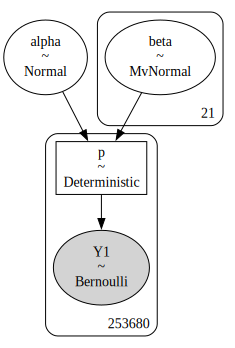

In [9]:
# Graph model
pm.model_to_graphviz(model)

In [10]:
# ADVI fit for the model
advi_fit = pm.fit(50000, method='advi', model=model)

Finished [100%]: Average Loss = 83,541


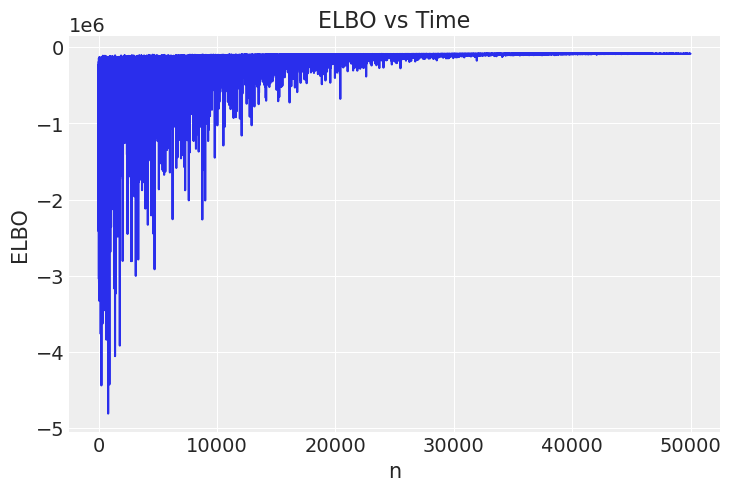

In [11]:
# Plot ELBO
advi_elbo = pd.DataFrame({'ELBO':-advi_fit.hist, 'n': np.arange(advi_fit.hist.shape[0])})
plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title('ELBO vs Time')
plt.show()

In [12]:
# Sample ADVI 
advi_trace = advi_fit.sample(5000)

In [13]:
# Summary for model parameters
az.summary(advi_trace, var_names=['alpha', 'beta'], round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.86,0.04,-1.93,-1.79,0.0,0.0,4852.42,4494.89,NaN
beta[0],0.78,0.04,0.71,0.85,0.0,0.0,4694.67,4188.55,NaN
beta[1],0.58,0.04,0.50,0.65,0.0,0.0,5105.11,4575.19,NaN
beta[2],-0.63,0.04,-0.69,-0.56,0.0,0.0,4989.91,4639.95,NaN
beta[3],0.36,0.01,0.33,0.38,0.0,0.0,4964.97,4600.80,NaN
beta[4],-0.11,0.04,-0.18,-0.04,0.0,0.0,5189.85,4860.68,NaN
beta[5],0.16,0.05,0.07,0.24,0.0,0.0,4961.00,4994.64,NaN
beta[6],0.35,0.04,0.27,0.43,0.0,0.0,4413.71,5021.27,NaN
beta[7],-0.18,0.04,-0.25,-0.11,0.0,0.0,4974.73,4777.04,NaN
beta[8],-0.08,0.04,-0.15,-0.01,0.0,0.0,4704.28,4827.75,NaN


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

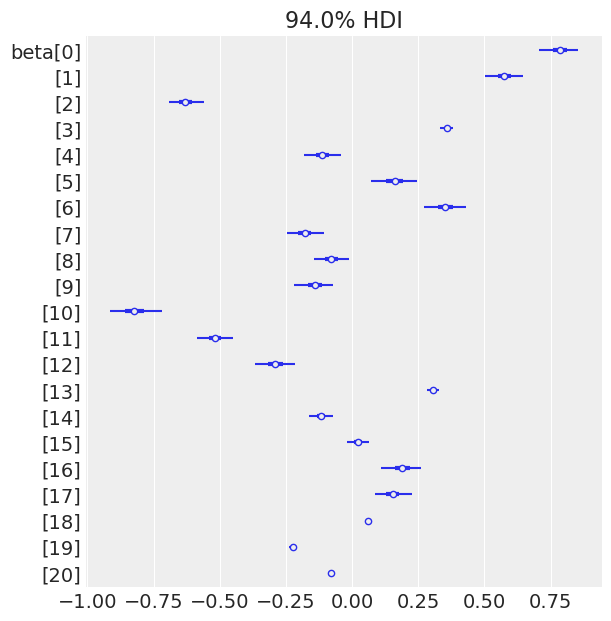

In [17]:
# Forest plots for model parameters
az.plot_forest(advi_trace,  var_names=['beta'])

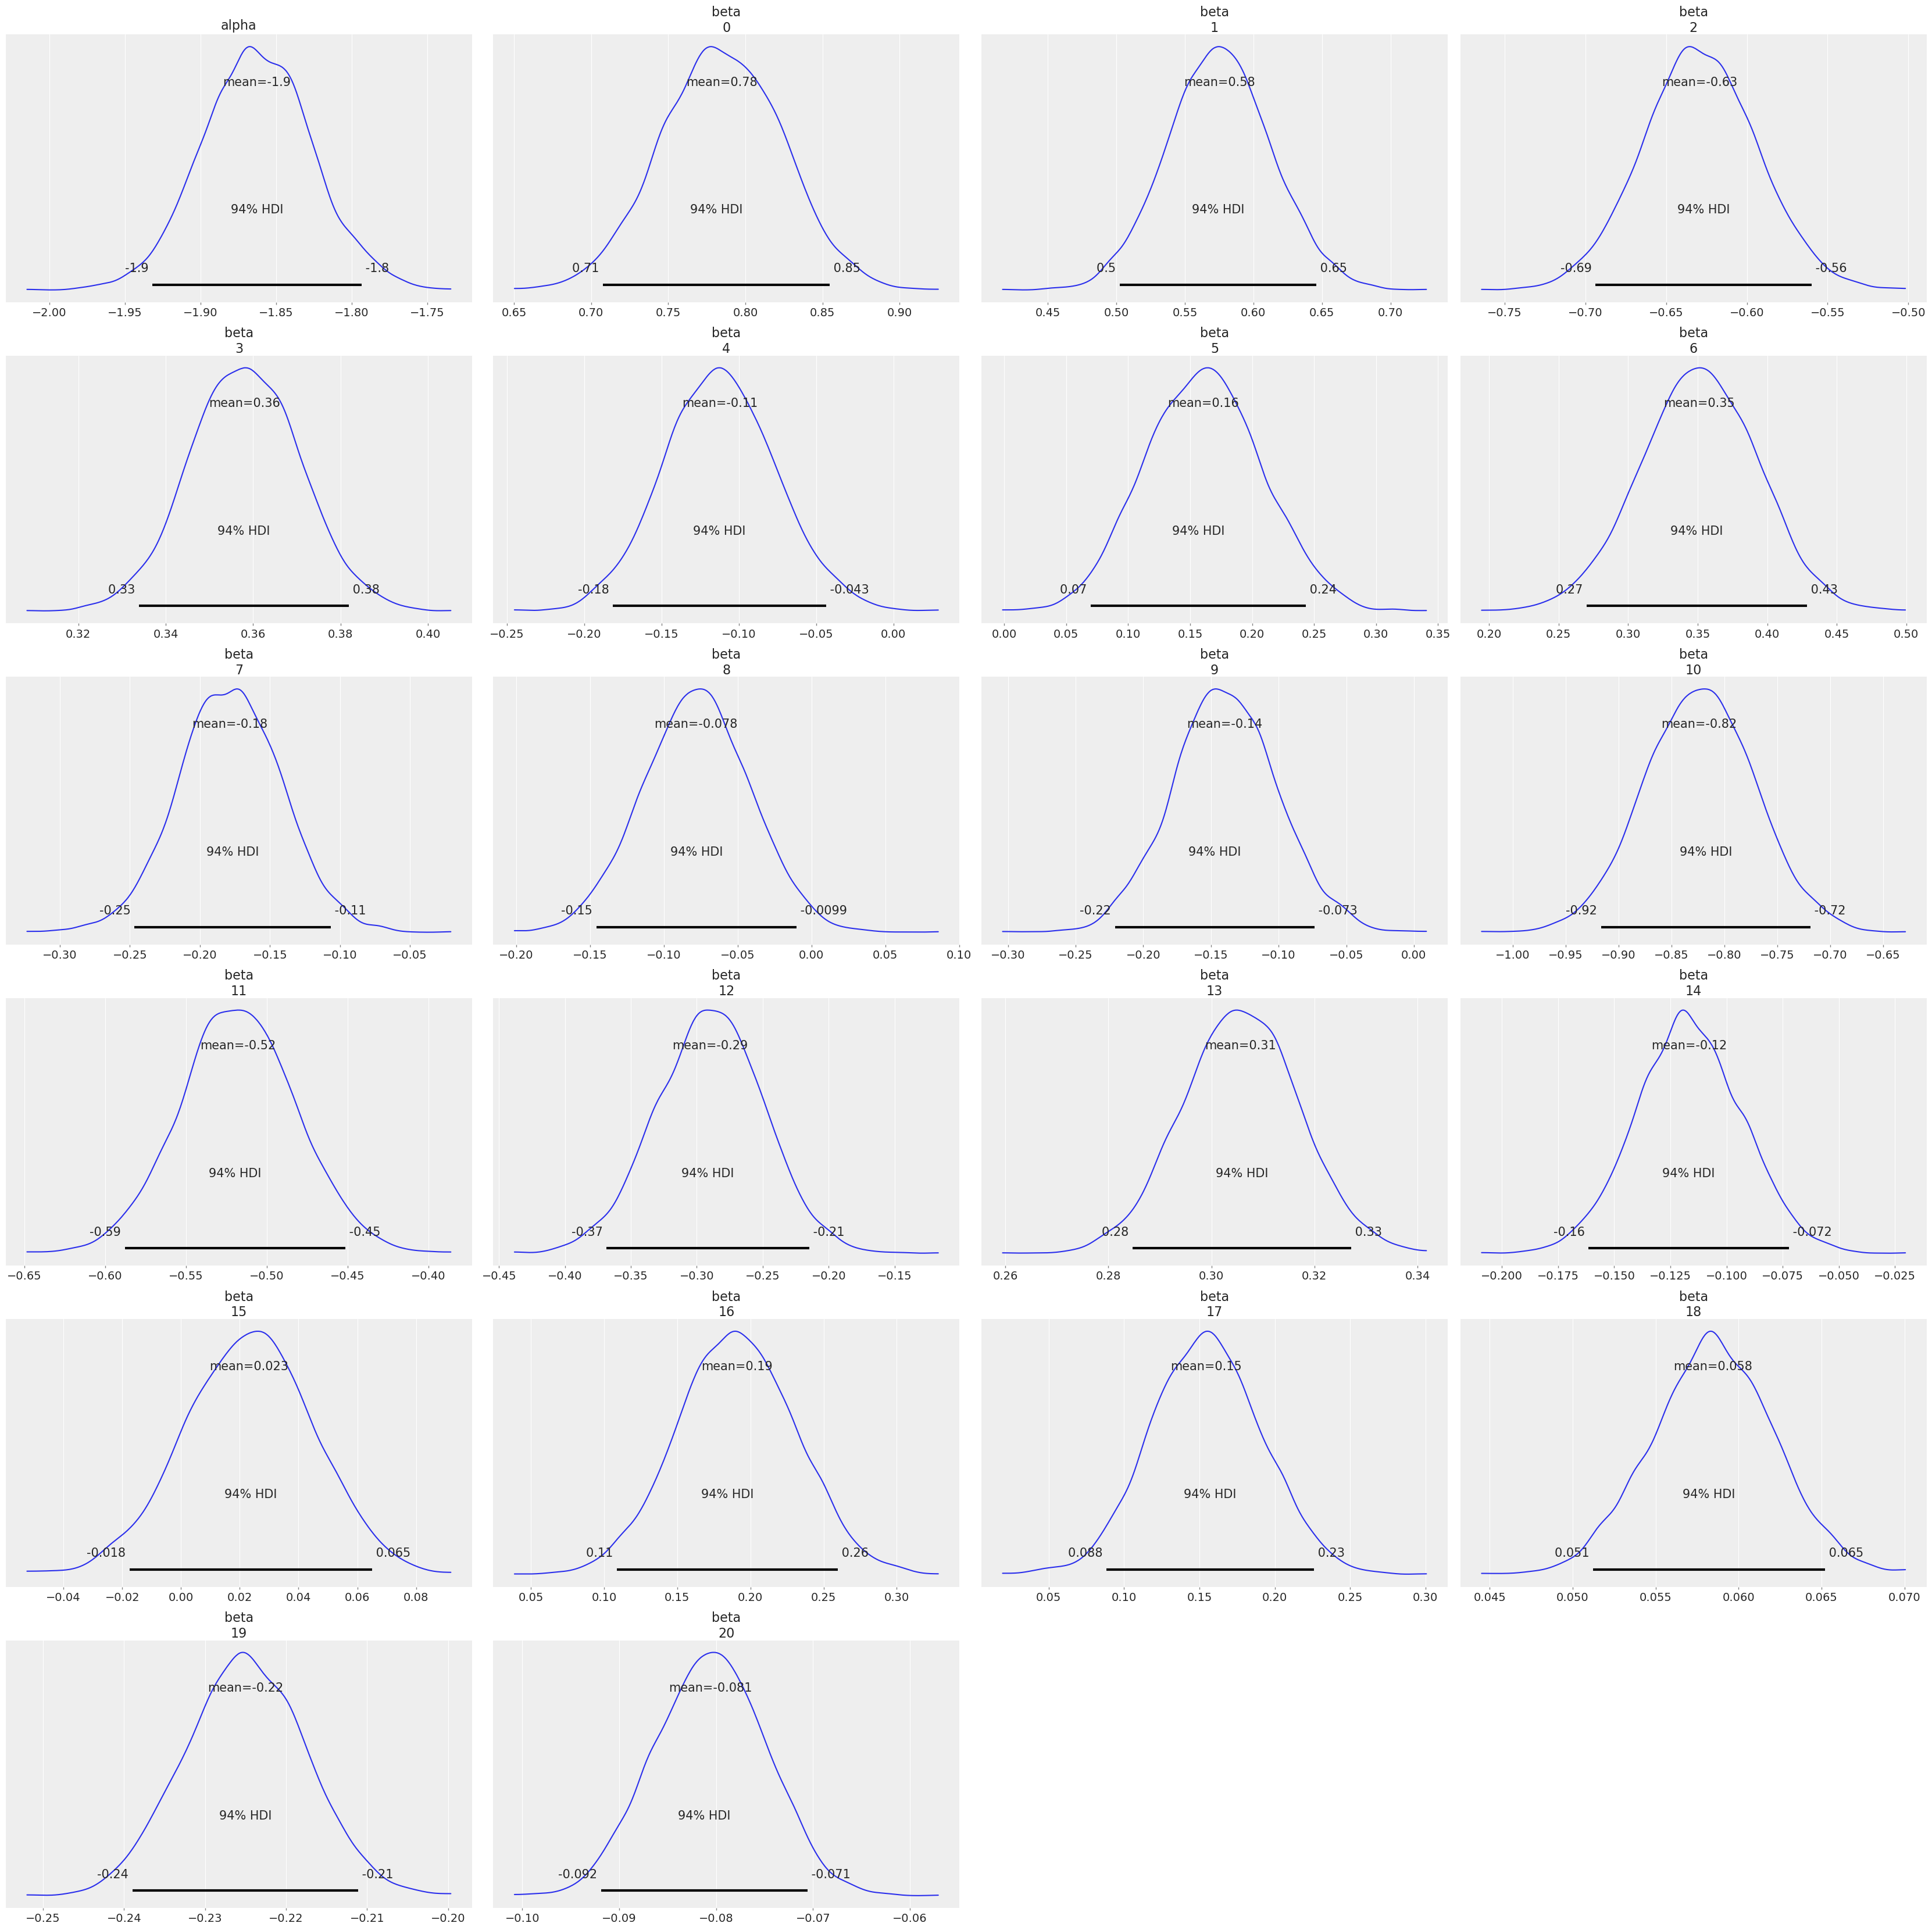

In [15]:
# Posterior plots for model parameters
az.plot_posterior(advi_trace, var_names=['alpha', 'beta'])
plt.show()